In [1]:
import os

In [2]:
os.chdir(r'E:\Masters\IN5000 - Final Project\AI-ForestWatch-Data\Netherlands data\NLD_shapefile\forest label shapefile')

# Read the shapefile using GeoPandas

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
NL_shapefile = gpd.read_file(r'E:\Masters\IN5000 - Final Project\AI-ForestWatch-Data\Netherlands data\NLD_shapefile\converted\landsgrens.shp')

In [5]:
dir(NL_shapefile)
#NL_shapefile.dtypes

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__re

In [10]:
NL_shapefile.transform

<bound method DataFrame.transform of    code  landsnaam                                           geometry
0  6030  Nederland  MULTIPOLYGON (((199549.696 308385.049, 199543....>

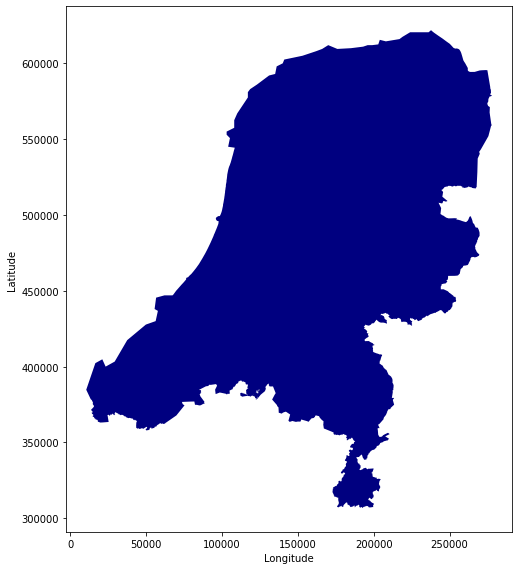

In [11]:
fig, ax = plt.subplots(1, figsize = (8,12))
NL_shapefile.plot(ax=ax, cmap='jet', legend = True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Read and convert shapefile to raster using GDAL

In [12]:
NL_shapefile.crs

<Derived Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [13]:
from osgeo import gdal, ogr, osr

In [15]:
input_shp = ogr.Open(r'E:\Masters\IN5000 - Final Project\AI-ForestWatch-Data\Netherlands data\NLD_shapefile\converted\landsgrens.shp')
source_layer = input_shp.GetLayer()
defn = source_layer.GetLayerDefn()
column_names = []
for n in range(defn.GetFieldCount()):
    fdefn = defn.GetFieldDefn(n)
    column_names.append(fdefn.name)

In [16]:
#column_names
source_layer.GetExtent()

(10425.156, 278026.09, 306846.198, 621876.3)

In [17]:
output_raster_location = r"E:\Masters\IN5000 - Final Project\AI-ForestWatch-Data\Netherlands data\NLD_shapefile\converted\Netherlands_shapefile.tiff"
pixel_size = 30
xmin, xmax, ymin, ymax = source_layer.GetExtent()
x_res = int(round((xmax - xmin) / pixel_size))
y_res = int(round((ymax - ymin) / pixel_size))
print("x_res:{}, y_res:{}".format(x_res, y_res))
target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1, gdal.GDT_UInt16,['COMPRESS=NONE'])
print(target_ds)

x_res:8920, y_res:10501
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000248A7CD1D50> >


In [18]:
target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0, -pixel_size))
srse = osr.SpatialReference()
proj = 'EPSG:28992'
srse.SetWellKnownGeogCS(proj)
target_ds.SetProjection(srse.ExportToWkt())
band = target_ds.GetRasterBand(1)
target_ds.GetRasterBand(1).SetNoDataValue(-9999)
band.Fill(-9999)
gdal.RasterizeLayer(target_ds, [1], source_layer, None, None, [1], options = ['ALL_TOUCHED = TRUE', 'ATTRIBUTE = bg2015'])
target_ds = None

# Open raster using xarray

In [19]:
import xarray as xr
import rasterio

In [20]:
raster = xr.open_rasterio(output_raster_location).squeeze()

<ipython-input-20-6c353b44422e>:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster = xr.open_rasterio(output_raster_location).squeeze()


In [21]:
raster

<xarray.DataArray (y: 10501, x: 8920)>
[93668920 values with dtype=uint16]
Coordinates:
    band     int32 1
  * y        (y) float64 6.219e+05 6.218e+05 6.218e+05 ... 3.069e+05 3.069e+05
  * x        (x) float64 1.044e+04 1.047e+04 1.05e+04 ... 2.78e+05 2.78e+05
Attributes:
    transform:   (30.0, 0.0, 10425.156, 0.0, -30.0, 621876.3)
    res:         (30.0, 30.0)
    is_tiled:    0
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [22]:
raster.shape

(10501, 8920)

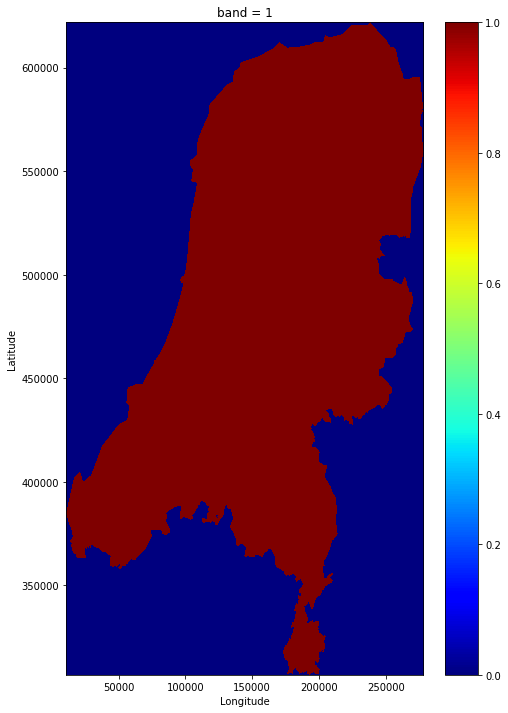

In [23]:
fig, ax = plt.subplots(1, figsize=(8,12))
raster.plot.imshow(cmap='jet')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [19]:
from osgeo import gdal
import numpy as np

og = gdal.Open(r"E:\Masters\IN5000 - Final Project\AI-ForestWatch-Data\GroundTruth\abbottabad_2015.tif")
band =  og.GetRasterBand(1)
array = np.array(band.ReadAsArray())
values = np.unique(array)
dir(og)

['AbortSQL',
 'AddBand',
 'AddFieldDomain',
 'AdviseRead',
 'BeginAsyncReader',
 'BuildOverviews',
 'ClearStatistics',
 'CommitTransaction',
 'CopyLayer',
 'CreateLayer',
 'CreateMaskBand',
 'DeleteLayer',
 'EndAsyncReader',
 'ExecuteSQL',
 'FlushCache',
 'GetDescription',
 'GetDriver',
 'GetFieldDomain',
 'GetFileList',
 'GetGCPCount',
 'GetGCPProjection',
 'GetGCPSpatialRef',
 'GetGCPs',
 'GetGeoTransform',
 'GetLayer',
 'GetLayerByIndex',
 'GetLayerByName',
 'GetLayerCount',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetNextFeature',
 'GetProjection',
 'GetProjectionRef',
 'GetRasterBand',
 'GetRootGroup',
 'GetSpatialRef',
 'GetStyleTable',
 'GetSubDatasets',
 'GetTiledVirtualMem',
 'GetTiledVirtualMemArray',
 'GetVirtualMem',
 'GetVirtualMemArray',
 'IsLayerPrivate',
 'RasterCount',
 'RasterXSize',
 'RasterYSize',
 'ReadAsArray',
 'ReadRaster',
 'ReadRaster1',
 'ReleaseResultSet',
 'ResetReading',
 'RollbackTransaction

In [28]:
# from osgeo import gdal
# import numpy as np

# og1 = gdal.Open(r"E:\Masters\IN5000 - Final Project\AI-ForestWatch-Data\Netherlands data\forest_label_2015_raster\forest_label_2015.tiff")
# band1 =  og1.GetRasterBand(1)
# array1 = np.array(band1.ReadAsArray())
# values1 = np.unique(array1)
# values1
og.RasterCount

1